# Linear Model for Climate Change Predictions

We use linear regression to predict to predict temperature, diurnal temperature range, precipitation, and 90th percentile precipitation from mean global temperature.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 

In [2]:
# convert from kg/m^2/s to mm/day
KGM2S_TO_MMDAY = 86400

In [3]:
# flatten latitude and longitude to one dimension
def flatten(data):
    return data

### Create Training Data
First, we create the training for our model. We train our model using 4 scenarios: historical, ssp126, ssp370, and ssp585.

In [4]:
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

In [5]:
# using 2nd ensemble member for historical data since 1st member has missing data
# TODO: try .mean(member)
#ytrain = xr.concat(
#    [xr.open_dataset(f'train_val/outputs_{s}.nc').sel(member=2 if s=='historical' else 1) for s in scenarios]
#    , dim='time')

In [5]:
# average data over ensemble members
ytrain = xr.concat(
    [xr.open_dataset(f'train_val/outputs_{s}.nc').mean('member') for s in scenarios]
    , dim='time')

C:\Users\kaits\anaconda3\Lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [10]:
ytrain['time'].data

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937,
       1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 20

In [7]:
# convert precipitation data to mm/day
ytrain['pr'] *= KGM2S_TO_MMDAY
ytrain['pr90'] *= KGM2S_TO_MMDAY

In [8]:
# mean temp averaged globally and over training simulations
weights = np.cos(np.deg2rad(ytrain.lat))
global_mean_temp = ytrain['tas'].weighted(weights).mean(['lat', 'lon']).to_numpy().reshape(-1,1)

### Fit Linear Regression Models
Next, we fit 4 linear regression models for each of the output variables.

In [9]:
output_vars = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

In [10]:
# create model for each variable
models = {out: LinearRegression(fit_intercept=False) for out in output_vars}

# fit models
for out in output_vars:
    models[out].fit(global_mean_temp, ytrain[out].stack(dim=['lat','lon']))

### Test Data
We load the test data and process it, then use it to make model predictions.

In [11]:
# load test data
ytest = xr.open_dataset(f'test/outputs_ssp245.nc')

In [12]:
# process test data
# average over ensemble members
for out in output_vars:
    ytest[out] = ytest[out].mean('member')

# convert precipitation data to mm/day
ytest['pr'] *= KGM2S_TO_MMDAY
ytest['pr90'] *= KGM2S_TO_MMDAY

In [13]:
# get mean temperature averaged globally
test_input = (ytest['tas']
              .weighted(weights)
              .mean(['lat', 'lon'])
              .to_pandas() # convert to pandas to use rolling average
              .rolling(10, min_periods=1)
              .mean()
              .to_numpy() # convert back to numpy to reshape
              .reshape(-1,1))

In [14]:
# get predictions on test data
outputs = {out: models[out].predict(test_input).reshape(86,96,144) for out in output_vars}

### Evaluate Model
We evaluate our model using the NRMSE defined in the ClimateBench paper.

In [39]:
def get_nrmse_spatial(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_spatial = np.sqrt(((truth - pred).mean('time')**2).weighted(weights).mean(['lat','lon'])).data
    return rmse_spatial / truth_total 

In [40]:
def get_nrmse_global(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    truth = truth.sel(time=slice(2080,None))
    pred = pred[-21:]
    truth_total = np.abs(truth.weighted(weights).mean(['lat', 'lon']).data.mean())
    rmse_global = np.sqrt((((truth - pred).weighted(weights).mean(['lat', 'lon']))**2).data.mean())
    return rmse_global / truth_total 

In [41]:
def get_nrmse(truth, pred):
    return get_nrmse_spatial(truth, pred) + 5 * get_nrmse_global(truth, pred)

In [1]:
nrmses = [
    [
        get_nrmse_spatial(Ytest[out], outputs[out]), 
        get_nrmse_global(Ytest[out], outputs[out]),
        get_nrmse(Ytest[out], outputs[out])
    ] 
    for out in output_vars]

nrmse_table = pd.DataFrame(data=nrmses, index=output_vars, columns=['spatial', 'global', 'total']).round(3)
nrmse_table

NameError: name 'output_vars' is not defined

### Plot true vs. predictions
We plot the true values vs. predictions, and also include their differences.

In [43]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [44]:
# turn output into dataarray to plot
xr_output=xr.Dataset(
    coords={'time': ytest.time.values, 'lat': ytest.lat.values, 'lon': ytest.lon.values})

# assign values to xr_output
for out in output_vars:
    xr_output[out] = (['time', 'lat', 'lon'],  outputs[out])

In [45]:
# variables for plot below
proj = ccrs.PlateCarree()
labels = [
    'Temperature(K)', 
    'Diurnal Temperature Range(K)', 
    'Precipitation(mm/day)', 
    'Extreme Precipitation(mm/day)'
]
vs = [5, 5, 1, 1, 1, 0.5, 2, 2, 1, 4, 4, 2]

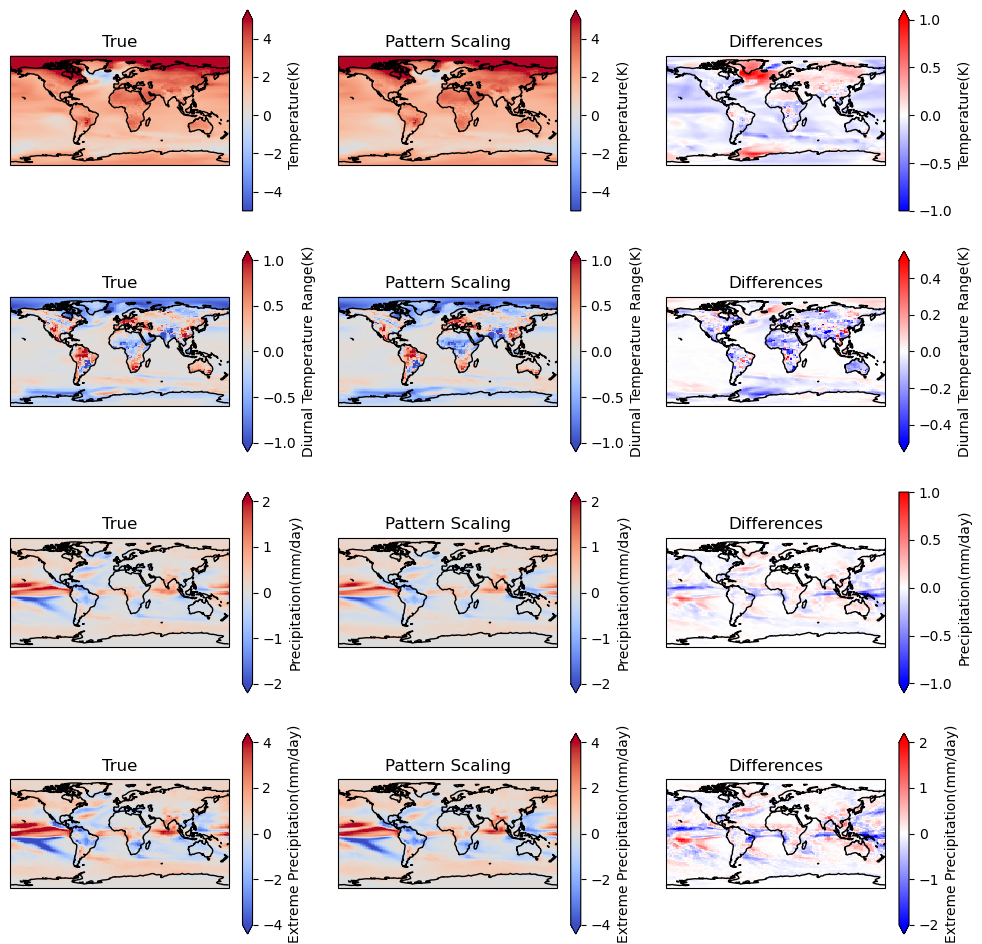

In [47]:
fig = plt.figure(figsize=(12, 12))

for var_num in range(len(output_vars)):
    out = output_vars[var_num]
    for plot_num in range(3):
        if plot_num == 0:
            data = ytest[out][-21:]
        elif plot_num == 1:
            data = xr_output[out][-21:]
        else:
            data = xr_output[out][-21:] - ytest[out][-21:]
        
        # plot params
        plot_id = 3 * var_num + plot_num + 1
        colormap = "bwr" if plot_num == 2 else "coolwarm"
        
        if plot_num == 0:
            ptitle = 'True'
        elif plot_num == 1:
            ptitle = 'Pattern Scaling'
        else:
            ptitle = 'Differences'
        
        # plot
        ax = plt.subplot(4, 3, plot_id, projection=proj)
        data.sel(time=slice(2080,None)).mean('time').plot(cmap=colormap, vmax=vs[plot_id - 1],
                                      cbar_kwargs={"label":labels[var_num]})
        plt.gca().coastlines()
        plt.setp(plt.gca(), ylabel = 'test1', title=ptitle)   
